<a href="https://colab.research.google.com/github/JuhiNayak/CMPE272-ESPProject/blob/master/Numeric_Project_LoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Loan Approval Prediction System

Our business case is to predict whether the bank loan will be approved or not to any applicant based on various features available in the datasets.
We have used the beloe mentioned two datasets.

Data Source:

Loan Prediction Problem Dataset: https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset

Lending Club Dataset: https://www.kaggle.com/wordsforthewise/lending-club

# Install and import libraries

In [ ]:
!pip install xgboost

In [ ]:
!pip install mlxtend --upgrade

Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.17.3)


In [ ]:
!pip install scikit-optimize

In [ ]:
# Modified from ...
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns; sns.set()
from skopt import BayesSearchCV
import mlxtend.evaluate
from mlxtend.evaluate import bias_variance_decomp
CV_N_REPEATS = 20
BINS = 10


# Access final dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls ./drive/My\ Drive/the-feature-finders/datasets/loan-prediction

Mounted at /content/drive
BankLoanApprovalFinalDataset1.csv	SPSS_loan_roc.sav
BankLoanApprovalFinalDataset.csv	test_Y3wMUE5_7gLdaTN.csv
BankLoanApprovalFinalMergedDataset.csv	train_u6lujuX_CVtuZ9i.csv
lending-club				usStatesWithMostDebtAbbr.csv
LoanPredictionProblemDescription.xlsx


In [ ]:
path = "/content/drive/My Drive/the-feature-finders/datasets/loan-prediction/BankLoanApprovalFinalMergedDataset.csv"
final_df = pd.read_csv(path)
final_df.head(5)

,Loan_Amount,Loan_Amount_Term,Credit_History,Loan_Status,Addr_State,Annual_Income,Employed,Purpose,Home_Ownership,dti,Rank,﻿State,Debt Total (Billions)
0,146.412162,360,1,1,CA,5849.0,1,4,1,30.510709,1,California,$152.80
1,128.000000,360,1,0,CA,6091.0,1,4,1,30.503228,1,California,$152.80
2,66.000000,360,1,1,CA,3000.0,1,4,1,30.577049,1,California,$152.80
3,120.000000,360,1,1,CA,4941.0,1,4,1,30.531795,1,California,$152.80
4,141.000000,360,1,1,CA,6000.0,1,4,1,30.506485,1,California,$152.80


In [ ]:
final_df = final_df[['Loan_Amount','Loan_Amount_Term','Credit_History','Loan_Status','Annual_Income','Employed','Purpose','Home_Ownership','dti','Rank']]
final_df.head(5)

,Loan_Amount,Loan_Amount_Term,Credit_History,Loan_Status,Annual_Income,Employed,Purpose,Home_Ownership,dti,Rank
0,146.412162,360,1,1,5849.0,1,4,1,30.510709,1
1,128.000000,360,1,0,6091.0,1,4,1,30.503228,1
2,66.000000,360,1,1,3000.0,1,4,1,30.577049,1
3,120.000000,360,1,1,4941.0,1,4,1,30.531795,1
4,141.000000,360,1,1,6000.0,1,4,1,30.506485,1


# Correlation Coefficients Heatmap

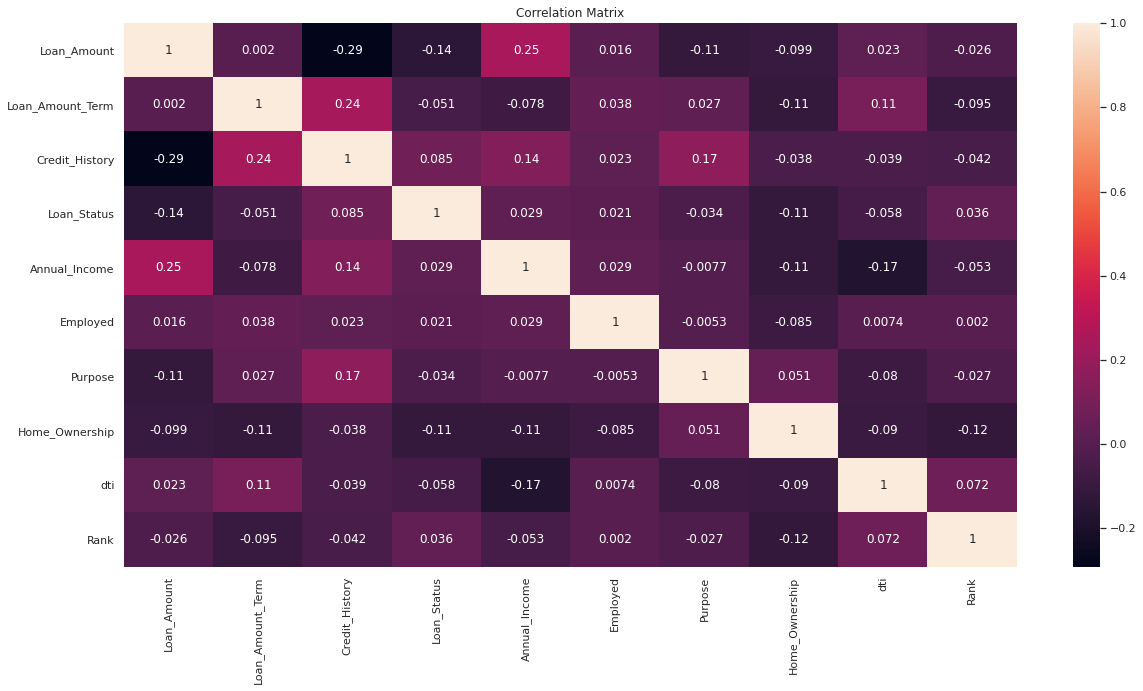

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Correlation Matrix')
sns.heatmap(final_df.corr(),annot=True)

By visualizing our data with Heatmap, we found a strong correlation between various features available in the dataset. Such as:
- Annual Income is highly correlated to the loan amount.
- Debt-to-income ratio (dti) is highly correlated to the loan amount term.

But, It didn't provide us much clarity about the correlation between the other columns. So we used Feature Importance technique to get to know a score for the input features based on how useful they are at predicting our target variable. Here, our target variable is Loan Status.


# Feature Importance

We are now proceeding with finding out the Feature Importance to know the most important features for our dataset based on the target feature.

In [ ]:
y = final_df['Loan_Status']

In [ ]:
final_df.drop(['Loan_Status'], axis=1, inplace=True)

[0.1785883  0.01680826 0.00556348 0.25431429 0.00672089 0.06759578
 0.0212728  0.28099665 0.16813954]


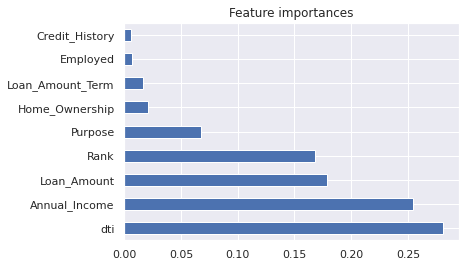

In [ ]:
model = ExtraTreesClassifier(criterion='gini') # “gini” for the Gini impurity and “entropy” for the information gain.
model.fit(final_df, y)
print(model.feature_importances_) # use inbuilt class feature_importances of tree based classifiers
# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=final_df.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature importances")
plt.show()

In [ ]:
feat_importances

Loan_Amount         0.178588
Loan_Amount_Term    0.016808
Credit_History      0.005563
Annual_Income       0.254314
Employed            0.006721
Purpose             0.067596
Home_Ownership      0.021273
dti                 0.280997
Rank                0.168140
dtype: float64

It's obvious that dti, annual income, loan amount, rank and purpose are the most important factors to predict the loan approval. So we are considering the most important features.

# Train-Test split

In [ ]:
X = final_df[['Purpose','Loan_Amount','Annual_Income','dti','Rank']]
# y = final_df[['Loan_Status']]

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

We are proceeding by trying various classifers because our business case is a classification problem i.e. at the end we are expecting a binary output.

# BayesSearchCV on RandomForestClassifier

In [ ]:
def apply(X, _regr):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

  # print('X_train\n', X_train.tail(2))

  print('y_train dist\n', y_train.value_counts())
  print('y_test dist\n', y_test.value_counts())

  # Train the model using the training sets
  model = _regr.fit(X_train, y_train)

  # Make predictions using the testing set
  y_pred = _regr.predict(X_test)

  
  unique_elements, counts_elements = np.unique(y_pred, return_counts=True)
  frequencies = np.asarray((unique_elements, counts_elements)).T

  print('y_pred distribution')
  print(frequencies)
  
  return y_test, y_pred

In [ ]:
algos = [
          LogisticRegression(),
          LogisticRegressionCV(),
          DecisionTreeClassifier(),
          RandomForestClassifier()
        ]

In [ ]:
algos_df = pd.DataFrame(columns = [])

row_index = 0

for algo in algos:
    algo_name = algo.__class__.__name__
    print('Applying ' + algo_name)
    y_test, y_pred = apply(X, algo)
    
    # predicted = algo.fit(X_train, y_train).predict(X_test)
    algos_df.loc[row_index, 'Name'] = algo_name
    algos_df.loc[row_index, 'Accuracy'] = accuracy_score(y_test, y_pred)
    algos_df.loc[row_index, 'Precission'] = precision_score(y_test, y_pred)
    algos_df.loc[row_index, 'Recall'] = recall_score(y_test, y_pred)
    algos_df.loc[row_index, 'F1'] = f1_score(y_test, y_pred)

    row_index += 1
    
# sort by Accuracy
algos_df.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    

algos_df

Applying LogisticRegression
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0   197]
 [    1 12282]]
Applying LogisticRegressionCV
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0    11]
 [    1 12468]]
Applying DecisionTreeClassifier
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[   0 3935]
 [   1 8544]]
Applying RandomForestClassifier
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0  1581]
 [    1 10898]]


,Name,Accuracy,Precission,Recall,F1
1,LogisticRegressionCV,0.705265,0.705486,0.999318,0.827080
0,LogisticRegression,0.704784,0.708354,0.988412,0.825270
3,RandomForestClassifier,0.683308,0.722518,0.894569,0.799391
2,DecisionTreeClassifier,0.594519,0.718984,0.697910,0.708290


In [ ]:
clf = RandomForestClassifier(n_estimators=200, max_depth=7)  # hyperparameters optimised using BayesSearchCV
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
if True:
    # Set to True if we want to run the BayesSearchCV process
    params = {'n_estimators': (130, 200),
              'max_depth': (7, 15)}

    optimiser = BayesSearchCV(clf, params, n_jobs=-1, n_iter=50)
    #opt = BayesSearchCV( SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, n_iter=32 )
    #executes bayesian optimization

    # note we're fitting on all the data, so we're optimising wrt to the test data (might be silly)
    optimiser.fit(X_train, y_train)

    print(optimiser.score(X_test, y_test), optimiser.best_params_)
    #pd.DataFrame(optimiser.cv_results_)

/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.6/dist-packa

0.6982931324625371 OrderedDict([('max_depth', 9), ('n_estimators', 140)])


In [ ]:
clf.score(X_test, y_test)

0.7017389213879317

In [ ]:
scores = cross_val_score(clf, X, y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), n_jobs=-1)
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Scores mean=0.71 +/- 0.00 (1 s.d.)


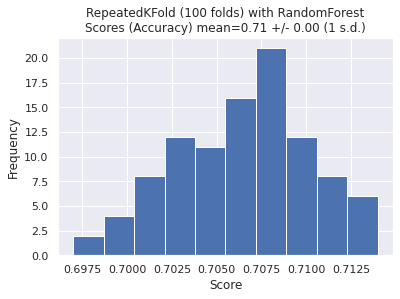

In [ ]:
score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with RandomForest\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

In [ ]:
algos1 = [
          LogisticRegression(),
          DecisionTreeClassifier(max_depth=7),
          RandomForestClassifier(n_estimators=140, max_depth=9)
        ]

In [ ]:
algos_df = pd.DataFrame(columns = [])

row_index = 0

for algo in algos1:
    algo_name = algo.__class__.__name__
    print('Applying ' + algo_name)
    y_test, y_pred = apply(X, algo)
    
    # predicted = algo.fit(X_train, y_train).predict(X_test)
    algos_df.loc[row_index, 'Name'] = algo_name
    algos_df.loc[row_index, 'Accuracy'] = accuracy_score(y_test, y_pred)
    algos_df.loc[row_index, 'Precission'] = precision_score(y_test, y_pred)
    algos_df.loc[row_index, 'Recall'] = recall_score(y_test, y_pred)
    algos_df.loc[row_index, 'F1'] = f1_score(y_test, y_pred)

    row_index += 1
    
# sort by Accuracy
algos_df.sort_values(by = ['Accuracy'], ascending = False, inplace = True)    

algos_df

Applying LogisticRegression
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0   215]
 [    1 12264]]
Applying DecisionTreeClassifier
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0   679]
 [    1 11800]]
Applying RandomForestClassifier
y_train dist
 1    35205
0    14708
Name: Loan_Status, dtype: int64
y_test dist
 1    8802
0    3677
Name: Loan_Status, dtype: int64
y_pred distribution
[[    0   328]
 [    1 12151]]


,Name,Accuracy,Precission,Recall,F1
2,RandomForestClassifier,0.704383,0.710394,0.980686,0.823939
0,LogisticRegression,0.702861,0.707681,0.986026,0.823982
1,DecisionTreeClassifier,0.701098,0.714915,0.958419,0.818950


After performing hypermeters tuning on RandomForestClassifier using BayesSearchCV, we got the best result with max_depth=9 and n_estimators=140. The score on RandomForestClassifier improves from .60 to .70 compared to the default parameters. This yields a similar score to the LogisticRegression model we created earlier.

# Muller loop Classifiers

## Model training and Classifier comparison

In [ ]:
names = ["XgBoost","Nearest Neighbors", "Linear SVM", "RBF SVM", #"Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]


classifiers = [
    XGBClassifier(),
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=9, n_estimators=140, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


Classifier = XgBoost, Score (test, accuracy) = 70.86, Training time = 2.00 seconds
Classifier = Nearest Neighbors, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Classifier = Linear SVM, Score (test, accuracy) = 70.53, Training time = 102.00 seconds
Classifier = RBF SVM, Score (test, accuracy) = 70.57, Training time = 838.00 seconds
Classifier = Decision Tree, Score (test, accuracy) = 70.53, Training time = 0.00 seconds
Classifier = Random Forest, Score (test, accuracy) = 70.63, Training time = 3.00 seconds
Classifier = Neural Net, Score (test, accuracy) = 70.52, Training time = 4.00 seconds
Classifier = AdaBoost, Score (test, accuracy) = 70.48, Training time = 1.00 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 70.05, Training time = 0.00 seconds
Classifier = QDA, Score (test, accuracy) = 69.86, Training time = 0.00 seconds
--------------------------------------------------------------------------------
Best --> Classifier = XgBoost, Score (test, accuracy) = 

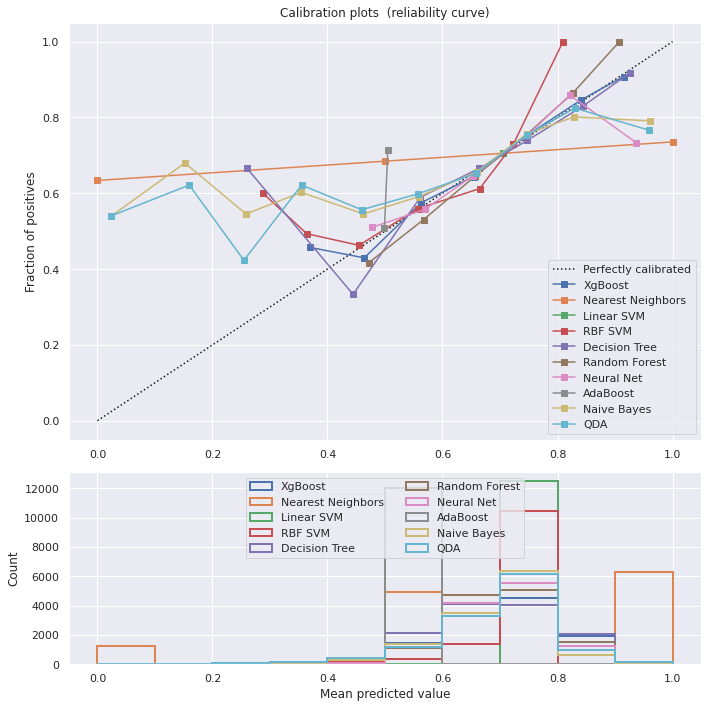

In [ ]:
max_score = 0.0
max_class = ''
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.localtime()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    diff = (time.mktime(time.localtime()) - time.mktime(start_time))
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (diff))
    
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))


ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

# Pickle and load the best classifier

## The Best Model

Please refer to this link for the file of Best Model:
https://drive.google.com/file/d/1-0hwL6ngo-BIF1Gne7ngFa2unf6QFCYi/view?usp=sharing

Model with additional "Rank" column: https://drive.google.com/file/d/1Xm6ktKe0Bu7QYW2koRVsjIegybu54aCc/view?usp=sharing

In [ ]:
file = open('final-model', 'wb')
pickle.dump(clf_best, file)
file.close()

In [ ]:
file = open('final-model', 'rb')
best_clf = pickle.load(file)
y_pred = best_clf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 173 3504]
 [ 132 8670]]
              precision    recall  f1-score   support

           0       0.57      0.05      0.09      3677
           1       0.71      0.99      0.83      8802

    accuracy                           0.71     12479
   macro avg       0.64      0.52      0.46     12479
weighted avg       0.67      0.71      0.61     12479



In [ ]:
score = accuracy_score(y_test, y_pred)
print('\nAccuracy score:', score)


Accuracy score: 0.708630499238721


# Confusion Matrix

In [ ]:

# Plot result from confusion matrix and score
def plot(score, cm):
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

  plt.figure(figsize=(9,9))
  sns.heatmap(cm_normalized, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {:.3f}'.format(score) 
  plt.title(all_sample_title, size = 15);

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 173 3504]
 [ 132 8670]]


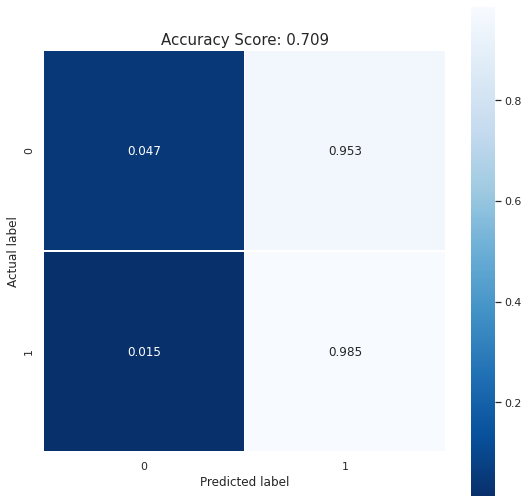

In [ ]:
plot(score, cm)

# Variance and Bias

### Check variance in prediction quality

In [ ]:
scores = cross_val_score(best_clf, X, y, cv=RepeatedKFold(n_repeats=CV_N_REPEATS), n_jobs=-1)
scores_est = scores.copy()
print(f"Scores mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)")

Scores mean=0.71 +/- 0.00 (1 s.d.)


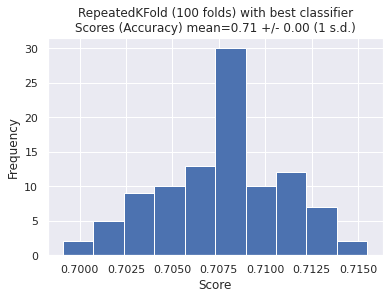

In [ ]:
score_line = f"Scores (Accuracy) mean={scores.mean():0.2f} +/- {scores.std():0.2f} (1 s.d.)"
fig, ax = plt.subplots()
pd.Series(scores).hist(ax=ax, bins=BINS)
ax.set_title(f"RepeatedKFold ({len(scores)} folds) with best classifier\n" + score_line);
ax.set_xlabel("Score")
ax.set_ylabel("Frequency");

### Calculate the Bias and Variance

In [ ]:
# estimate bias and variance
#best_clf_filtered = best_clf.reset_index(drop=True, inplace=True)
for i in range(0, y_train.shape[0]):
  try:
    y_train[i]
  except:
    y_train[i] = 0
mse, bias, var = bias_variance_decomp(best_clf, X_train, y_train, X_test, y_test, loss='mse', num_rounds=200, random_seed=1)
# summarize results
print('MSE: %.3f' % mse)
print('Bias: %.3f' % bias)
print('Variance: %.3f' % var)

MSE: 0.299
Bias: 0.289
Variance: 0.010


We can see that the model has a low bias and a low variance. Also, the sum of the bias and variance equals the average expected loss (MSE).
 

# Conclusion



1. Feature importance helped us in finding the best features for our business case.
2. BayesSearchCV helped us in finding the optimal tree depth and ultimately used it in muller loop.
3. Using those features and muller loop, we applied different classifiers and compared the results.
4. XgBoost is the best classifier for our business case which gave the accuracy of  0.708

# References

https://drive.google.com/file/d/1qfDT6Cx62q6rmxBdl1fTpJGwaBIefSI2/view
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html  
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/Logistic_Regression/LogisticRegression_MNIST.ipynb  
https://towardsdatascience.com/a-relook-on-random-forest-and-feature-importance-2467dfab5cca  
https://github.com/ianozsvald/data_science_delivered/blob/master/ml_creating_correct_capable_classifiers.ipynb
https://github.com/mGalarnyk/Python_Tutorials/tree/master/Sklearn
https://github.com/ianozsvald/data_science_delivered/blob/master/ml_creating_correct_capable_classifiers.ipynb
https://github.com/aarsanjani/applied-ml-2020/blob/master/MullerLoop.ipynb
https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
https://neuraspike.com/blog/estimate-bias-variance-python/